In [1]:
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import datetime
from io import StringIO
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [2]:
!pip install pdfminer

^C
Traceback (most recent call last):
  File "/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 104, in create_command
    module = importlib.import_module(module_path)
  File "/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>"

In [2]:
%matplotlib inline

In [3]:
def convert_to_datetime(date):
    date = datetime.datetime.strptime(date, '%m.%d')
    date = date.replace(2020)
    
    return date

In [4]:
def convert_to_decimal(amount):
    num = ' '.join(amount.split())
    n_split = num.split(' ')
    
    rs = 0
    for n in n_split:
        b = n.find('억') 
        k10 = n.find('만')
        k = n.find('천')

        if b > 0:
            n = change_to_number(n)
            n = n * 100000000

        if k10 > 0:
            n = change_to_number(n)
            n = n * 10000

        if k > 0:
            n = change_to_number(n)
            n = n * 1000

        rs += n
        
    return rs

In [5]:
def calculate_daegu(amount):
    supply_daegu = amount * 246.5/5164
    rs = round(supply_daegu, 2)
    
    return rs

In [6]:
def calculate_weight(supply_daegu):
    used_mask_pp_daegu = supply_daegu * 3.5
    scale_to_kg = used_mask_pp_daegu * 0.001
    rs = round(scale_to_kg, 2)
    
    return rs

In [7]:
def calculate_price(weight):
    price = weight * 637
    rs = round(price, 2)
    
    return price

In [8]:
def change_to_number(number):
        list_of_numbers = re.findall(r'\d+', number)
        return int(''.join(list_of_numbers))

In [9]:
def rid_of_decimal_point(n_amount):
    i = n_amount.find('.')

    if i > 0:
        tmp_n = list(n_amount)
        tmp_n.pop(i)
        tmp_n.pop(i)

        n_amount = ''

        for t in tmp_n:
            n_amount += t
            
    return n_amount

In [10]:
def export_date_amount_of_public(pdfs):

    date = list()
    amount = list()
    
    for pdf in pdfs:
        # Read pdf as text
        text = read_pdf_PDFMINER(pdf)
        
        # Make text as list by line('\n')
        text_li = list()
        tmp_str = str()

        for t in text:
            if t != '\n':
                tmp_str += t
            else:
                text_li.append(tmp_str)
                tmp_str = str()

        # Remove empty element of list
        text_li = list(filter(None, text_li))

        # Find the line that has the word '오늘', get its index. 
        today_idx = 0
        for idx, l in enumerate(text_li):
            if '오늘(' in l:
                today_idx = idx
                break
                
        # Get next line of '오늘', because there are some report 
        # that has both the day report and the next day report
        # Combine those lines
        report_sentence = text_li[today_idx] + text_li[today_idx+1]

        # Check if the sentence has the work '내일'
        # if there is, returns its index
        # if not, returns -1
        idx = report_sentence.find('내일')
        
        # There is no the word '내일'
        if idx == -1:
            # Get the date
            date.append(re.findall('\d.\d{1,2}', report_sentence)[0])
            
            # Get the amount
            n_amount = re.findall('총(.*?)개', report_sentence)[0]
            
            # If this number has point,
            # Get rid of below decimal point
            n_amount = rid_of_decimal_point(n_amount)
            amount.append(n_amount)

        # There is the word '내일'
        else:
            today = report_sentence[0:idx]
            tomorrow = report_sentence[idx:-1]

            date.append(re.findall('\d.\d{1,2}', today)[0])
            
            n_amount = re.findall('총(.*?)개', today)[0]
            n_amount = rid_of_decimal_point(n_amount)
            amount.append(n_amount)

            date.append(re.findall('\d.\d{1,2}', tomorrow)[0])
            n_amount = re.findall('총(.*?)개', tomorrow)[0]
            n_amount = rid_of_decimal_point(n_amount)
            amount.append(n_amount)

    return pd.DataFrame({'date':date, 'amount': amount})

In [11]:
def read_pdf_PDFMINER(pdf_file_path):
    """
    pdf_file_path: 'dir/aaa.pdf'로 구성된 path로부터 
    내부의 text 파일을 모두 읽어서 스트링을 리턴함.
    https://pdfminersix.readthedocs.io/en/latest/tutorials/composable.html
    """
    output_string = StringIO()
    with open(pdf_file_path, 'rb') as f:
        parser = PDFParser(f)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)
    return str(output_string.getvalue())

In [12]:
# Read file path and name
pdfs = glob.glob('data/public/*.pdf')

# # Convert pdf files as text
df_mask_raw = export_date_amount_of_public(pdfs)

# Save raw data
df_mask_scale = df_mask_raw.copy()

# Scale the raw data
df_mask_scale['amount'] = df_mask_scale['amount'].apply(convert_to_decimal)
df_mask_scale['date'] = df_mask_scale['date'].apply(convert_to_datetime)

# Fill the missing data, which the report form is too different with others
date_missing = [pd.to_datetime('2020-3-13'),pd.to_datetime('2020-3-23'),pd.to_datetime('2020-3-30'),
               pd.to_datetime('2020-4-6'),pd.to_datetime('2020-4-13'),pd.to_datetime('2020-4-14'),
               pd.to_datetime('2020-4-15'),pd.to_datetime('2020-4-16'),pd.to_datetime('2020-3-18'),
               pd.to_datetime('2020-4-19'),pd.to_datetime('2020-4-20'),pd.to_datetime('2020,-4-25'),
               pd.to_datetime('2020-4-26')]
amount_missing = [8020000, 8260000, 11110000, 
                  10130000, 10180000, 9890000, 
                  9710000, 8870000, 7230000, 
                  1890000, 9370000, 7800000, 
                  1790000]
df_missing = pd.DataFrame({'date':date_missing, 'amount': amount_missing})

# Merge scale and missing
df_rs = pd.concat([df_mask_scale, df_missing])
df_rs = df_rs.sort_values(by=['date'])
df_rs = df_rs.set_index('date')

# Resample the data weekly and Show as graph
weekly_df = df_rs.resample('W-Sat', how={'all_news_num':np.sum})
weekly_df.columns = ['amount']
weekly_df['daegu'] = weekly_df['amount'].apply(calculate_daegu)
weekly_df['weight'] = weekly_df['amount'].apply(calculate_weight)
weekly_df['price'] = weekly_df['amount'].apply(calculate_price)

/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/sanghyunbyun/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/pandas/core/resample.py:810: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  r = r.aggregate(how)


In [22]:
pd.options.display.float_format = '{:.2f}'.format
weekly_df.apply(np.sum, axis=0)

amount      917992000.00
daegu        43819718.81
weight        3212972.00
price    584760904000.00
dtype: float64

In [29]:
weekly_df_1 = weekly_df.transpose()
weekly_df_1.columns = ['3/1', '3/2', '3/3', '3/4',
          '4/1', '4/2', '4/3', '4/4',
          '5/1', '5/2', '5/3', '5/4',
          '6/1', '6/2', '6/3', '6/4', '6/5',
          '7/1', '7/2']

weekly_df_1

,3/1,3/2,3/3,3/4,4/1,4/2,4/3,4/4,5/1,5/2,5/3,5/4,6/1,6/2,6/3,6/4,6/5,7/1,7/2
amount,34370000.00,47860000.00,59730000.00,58785000.00,66606000.00,59609000.00,48872000.00,38942000.00,54888000.00,51107000.00,45094000.00,46509000.00,56173000.00,50427000.00,46069000.00,45359000.00,51578000.00,41007000.00,15007000.00
daegu,1640628.39,2284564.29,2851170.60,2806061.68,3179391.75,2845394.75,2332871.42,1858869.67,2620041.05,2439557.61,2152531.18,2220075.23,2681379.65,2407098.28,2199072.13,2165180.77,2462040.47,1957441.03,716348.86
weight,120295.00,167510.00,209055.00,205747.50,233121.00,208631.50,171052.00,136297.00,192108.00,178874.50,157829.00,162781.50,196605.50,176494.50,161241.50,158756.50,180523.00,143524.50,52524.50
price,21893690000.00,30486820000.00,38048010000.00,37446045000.00,42428022000.00,37970933000.00,31131464000.00,24806054000.00,34963656000.00,32555159000.00,28724878000.00,29626233000.00,35782201000.00,32121999000.00,29345953000.00,28893683000.00,32855186000.00,26121459000.00,9559459000.00


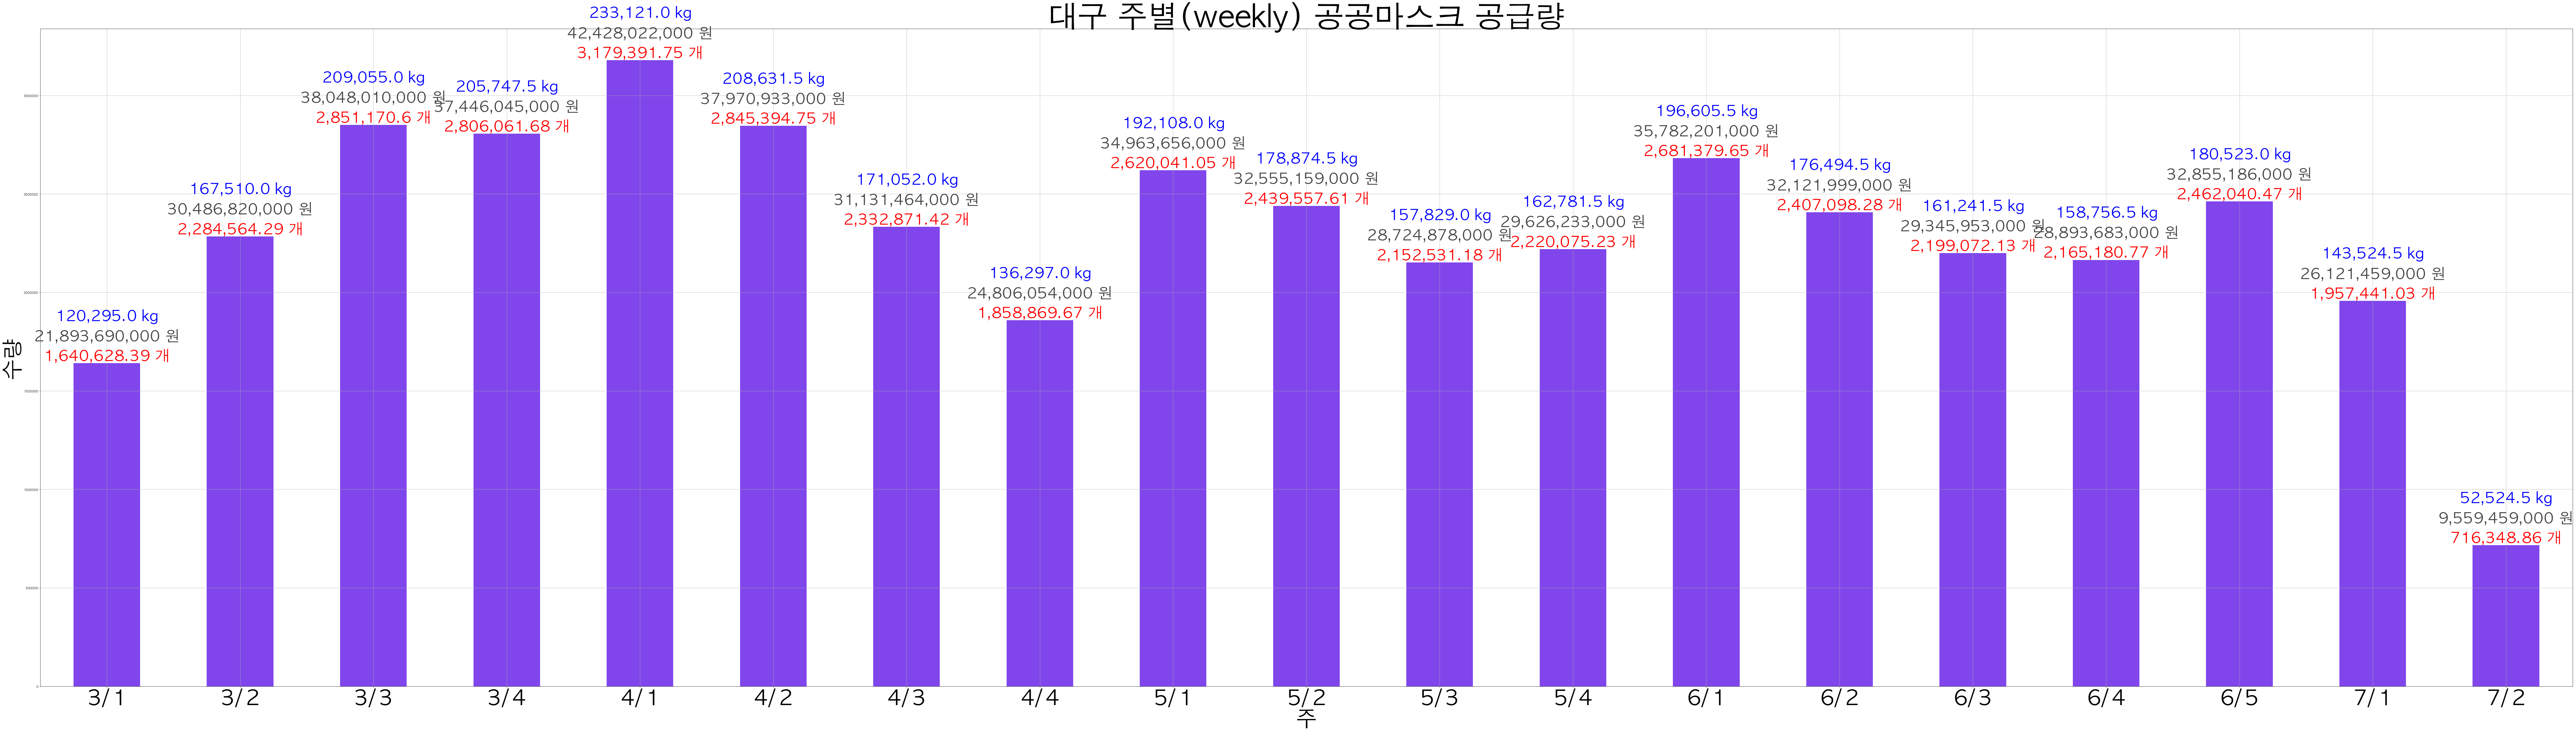

In [21]:
x_index = ['3/1', '3/2', '3/3', '3/4',
          '4/1', '4/2', '4/3', '4/4',
          '5/1', '5/2', '5/3', '5/4',
          '6/1', '6/2', '6/3', '6/4', '6/5',
          '7/1', '7/2']
x_pos = np.arange(len(weekly_df.index))

plt.rcParams["figure.figsize"] = (150, 40)
plt.rcParams['font.family'] = 'AppleGothic'

weekly_df['daegu'].plot.bar(color='#8046eb')
plt.grid()
plt.title("대구 주별(weekly) 공공마스크 수거량", fontsize=100)
plt.xlabel("주", fontsize=70)
plt.ylabel("수량", fontsize=70)
plt.xticks(x_pos, x_index, fontsize=70, rotation=0)

for x, y in enumerate(list(weekly_df['daegu'])):
    txt = str(format(y, ',') + ' 개')
    plt.text(x, y, txt, fontsize=50, color='#ff0000', ha='center', va='bottom')

for x, y in enumerate(list(weekly_df['price'])):
    txt = str(format(y, ',')+ ' 원')
    plt.text(x, weekly_df['daegu'][x]+100000, txt, fontsize=50, color='#444444', ha='center', va='bottom')

for x, y in enumerate(list(weekly_df['weight'])):
    txt = str(format(y, ',') + ' kg')
    plt.text(x, weekly_df['daegu'][x]+200000, txt, fontsize=50, color='#0000ff', ha='center', va='bottom')

plt.show()